In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Speech_classification/'

Mounted at /content/drive
/content/drive/MyDrive/Speech_classification


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from tqdm.notebook import tqdm
import random

import librosa
import librosa.display as dsp
import IPython.display as ipd

warnings.filterwarnings(action='ignore')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
sr = 20000

몇 개의 데이터를 샘플링하여 살펴보면 모두 다른 길이를 가지고 있음
길이를 맞춰야 함을 의미

In [6]:
train_file_names = train["file_name"].to_numpy()
test_file_names = test["file_name"].to_numpy()
target = train["label"].to_numpy()

def load_audio(file_names, target, path):   
  audios = []
  for audio in tqdm(file_names):
    an_audio, _ = librosa.load(path+audio, sr=sr)
    audio_array = np.array(an_audio)
    audios.append(audio_array)
  audios = np.array(audios)

  targets = target.copy()

  return audios, targets

In [10]:
audio_train, target_train = load_audio(train_file_names, target, path='./dataset/train/')
audio_test, _ = load_audio(test_file_names, np.array([None]), path='./dataset/test/')

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

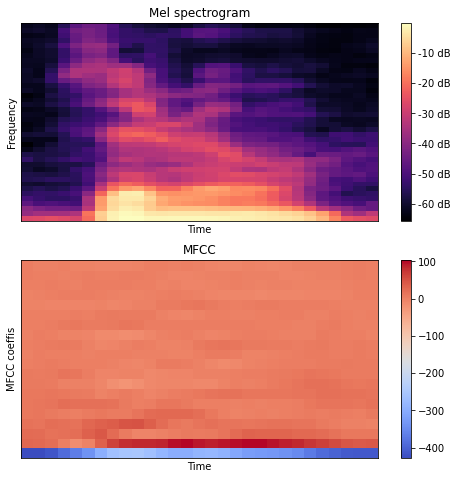

In [11]:
plt.figure(figsize=(8,8))
ax = plt.subplot(2, 1, 1)

ax = plt.subplot(2, 1, 1)
S = librosa.feature.melspectrogram(audio_train[15], sr=sr, n_mels=40)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr)
plt.title('Mel spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

ax = plt.subplot(2, 1, 2)
mfcc = librosa.feature.mfcc(audio_train[15], sr=sr, n_mels=40)
librosa.display.specshow(mfcc, sr=sr)
plt.title('MFCC')
plt.xlabel("Time")
plt.ylabel("MFCC coeffis")
plt.colorbar()
plt.show()

In [12]:
def random_pad(mels, pad_size, mfcc=True):

  pad_width = pad_size - mels.shape[1]
  rand = np.random.rand()
  left = int(pad_width * rand)
  right = pad_width - left
  
  if mfcc:
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
  else:
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')
  return mels

In [13]:
size = 40
pad_size = 40
repeat_size = 5

In [14]:
audio_mels = []
audio_mfcc = []

for y in audio_train:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)
  
  for i in range(repeat_size):
    audio_mels.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    audio_mfcc.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

In [15]:
audio_mels_array_test = []
audio_mfcc_array_test = []

for y in audio_test:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)

  audio_mels_array_test.append(random_pad(mels, pad_size=pad_size, mfcc=False))
  audio_mfcc_array_test.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

In [16]:
audio_mels_array = np.array(audio_mels, np.float64)
audio_mfcc_array = np.array(audio_mfcc, np.float64)

audio_mels_array_test = np.array(audio_mels_array_test, np.float64)
audio_mfcc_array_test = np.array(audio_mfcc_array_test, np.float64)

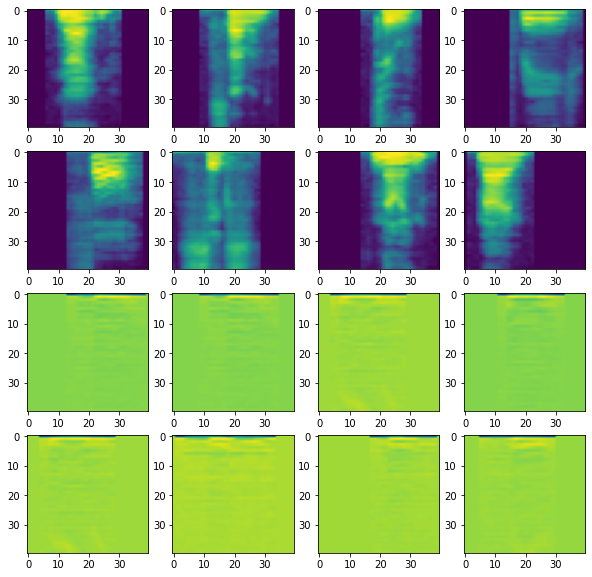

In [17]:
target_num = 2
target_num_idx = np.where(target_train==target_num)[0]
target_num_idx = np.random.choice(target_num_idx,16)

plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)

for i, idx in enumerate(target_num_idx):
  ax = plt.subplot(4, 4, i + 1)
  if i<8:
    plt.imshow(audio_mels_array[idx], aspect='auto')
  else:
    plt.imshow(audio_mfcc_array[idx], aspect='auto')

In [18]:
from sklearn.model_selection import train_test_split

repeated_target = np.repeat(target_train,repeat_size)
# x_train, x_val, y_train, y_val = train_test_split(audio_cqt_array, repeated_target, test_size=0.2, random_state=813, stratify=repeated_target)

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Input, DepthwiseConv2D, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

In [20]:
def residual_block(x, filters_in, filters_out):
    shortcut = x
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(filters_in, kernel_size=(3, 3), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)  
    x = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    shortcut_channel = x.shape.as_list()[0]
    
    if shortcut_channel != filters_out:
        shortcut = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(shortcut)
        
    x = Add()([x, shortcut])
    return ReLU()(x)

In [21]:
def build_model():

  inputs = tf.keras.layers.Input(shape=(size,pad_size,1))

  outputs = Conv2D(16,(3,3),activation=None,padding='same',kernel_initializer='he_normal')(inputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = MaxPool2D((2,2))(outputs)

  outputs = residual_block(outputs, 16, 32)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 32, 32)
  # outputs = residual_block(outputs, 32, 32)
  outputs = residual_block(outputs, 32, 64)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 64, 64)
  # outputs = residual_block(outputs, 64, 64)
  # outputs = MaxPool2D((2,2))(outputs)

  outputs = GlobalAveragePooling2D()(outputs)
  # outputs = Flatten()(outputs)

  outputs = Dense(32,activation=None,kernel_initializer='he_normal')(outputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = Dropout(0.5)(outputs)

  outputs = Dense(10,activation='softmax')(outputs)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# model = build_model()
# model.summary()

In [22]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

acc_list = []
pred_list = []
skf = StratifiedKFold(n_splits=5)

for fold,(train_index, val_index) in enumerate(skf.split(audio_mels_array, repeated_target)):

  print(f'\n********** {fold+1} fold **********')

  preds_val_list = []
  ### melspectrogram ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mels_array[train_index], audio_mels_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"model.res_test_0615_mels_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mels_array_test))
  print(f'mels_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### mfcc ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mfcc_array[train_index], audio_mfcc_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"model.res_test_0615_mfcc_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mfcc_array_test))
  print(f'mfcc_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### ensemble ###
  val_pred_result = preds_val_list[0].copy()
  for i in range(1, len(preds_val_list)):
      val_pred_result += preds_val_list[i]
  val_pred_label = np.argmax(val_pred_result, axis=1)
  en_acc = accuracy_score(y_val,val_pred_label)
  acc_list.append(en_acc)
  print(f'ensemble_model_acc : {en_acc:.4f}')

print(f'\n\nmean_acc : {np.mean(acc_list):.4f}')


********** 1 fold **********
mels_model_acc : 0.9375
mfcc_model_acc : 0.9400
ensemble_model_acc : 0.9775

********** 2 fold **********
mels_model_acc : 0.9600
mfcc_model_acc : 0.9375
ensemble_model_acc : 0.9650

********** 3 fold **********
mels_model_acc : 0.9425
mfcc_model_acc : 0.9225
ensemble_model_acc : 0.9825

********** 4 fold **********
mels_model_acc : 0.9375
mfcc_model_acc : 0.9525
ensemble_model_acc : 0.9700

********** 5 fold **********
mels_model_acc : 0.9275
mfcc_model_acc : 0.9075
ensemble_model_acc : 0.9300


mean_acc : 0.9650


In [23]:
test_pred_result = pred_list[0].copy()
for i in range(1, len(pred_list)):
    test_pred_result += pred_list[i]

submission['label'] = np.argmax(test_pred_result, axis=1)
submission.head()
submission.to_csv('./ens.csv', index=False) 